Project step overview

In [132]:
## imports
import numpy as np
import networkx as nx
import scipy.stats as stats
import pandas as pd
import sklearn as sk
import itertools
import os
from bed_reader import open_bed
from IPython.display import SVG
from sknetwork.embedding import LouvainNE
from sknetwork.embedding import LouvainEmbedding
from sknetwork.visualization import svg_graph, svg_bigraph
from networkx.algorithms import bipartite
from networkx.algorithms import community
from scipy import sparse
from sknetwork.hierarchy import LouvainHierarchy
from sknetwork.hierarchy import cut_straight, dasgupta_score, tree_sampling_divergence
from sknetwork.visualization import svg_graph, svg_bigraph, svg_dendrogram
from sklearn.neighbors import NearestNeighbors
from scipy.stats import chi2_contingency
from scipy.sparse import diags

In [133]:
def get_diagonal(df, width) : # convert SNPxSNP matrix as a result of cramer's to diagonal
    mid = df[df.shape(0)]
    arr = []
    result = np.empty(arr)
    for i in df:
        for j in df.T:
            if abs((i - j)) > width:
                result.append(j)

    return result

In [179]:
## get database workspace
file_name = '/Users/rishasurana/Library/CloudStorage/GoogleDrive-rsurana@usc.edu/.shortcut-targets-by-id/1I-Ssaub3M29w33JyrvO7HVv9laffGidc/chromosome_17_bed_bim_fam_data/ukb22418_c13_b0_v2.bed'
## read bed and select values
bed = open_bed(file_name)
print(bed.shape)
values = bed.read(index=np.s_[0:71,0:71])
print(values.shape)
values = np.array(values)

(488377, 26806)
(71, 71)


SAMPLE build Cramer's correlation matrix
note: Do not use, use SNPcorrelation.ipynb

In [135]:
def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  
  return stat/(obs*mini)

In [171]:
import warnings ## temporarily hide NaN division warnings
warnings.filterwarnings("ignore")

rows= []

for var1 in values:
  col = []
  for var2 in values.T:
    cramers =cramers_V(var1, var2) # Cramer's V test
    col.append(round(cramers,5)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results)

df



AttributeError: 'list' object has no attribute 'T'

Use the following cramer's

In [177]:
# create value array to store selected snp values

# apoe = np.array(["rs440446", rs877973", "rs769449", "rs769450", "rs429358", "rs7412"])
values = []
snp_count = 0
for chrom in range(19,20): # change to 1,23 for full genome
  bed = open_bed(file_name)
  id_to_index = dict([(int(id), index) for index, id in enumerate(bed.iid)])
  snp_to_index = dict([(sid, index) for index, sid in enumerate(bed.sid)])
  # indeces (lines) of bed file where subj id is in id_list (do id_list[subset])
  pos = np.where(np.in1d(bed.iid, bed.sid)) # change to 100

  # ##
  # ifapoe = np.where(np.in1d(bed.sid,apoe))
  # values = bed.read(index=np.s_[pos,ifapoe])
  # snp_count = values.shape[1]
  # print(values)
  # ##

  for snp in bed.sid: # change to bed.sid # first n snps by each other
    snp_ind = snp_to_index[snp] 
    # if snp_ind % 1000 == 0:
    values.append(bed.read(index=np.s_[pos,snp_ind])) # 0,1,2,nan values of SNP
    snp_count += 1

  print("chrom", str(chrom), "SNPs =", str(snp_count))

chrom 19 SNPs = 26806


In [181]:
# Cramers V
SNP = 71

cramers = np.zeros((SNP,SNP)) # should be bed.sid_count,bed.sid_count
distances = np.zeros((SNP,SNP))

for snp1 in range(SNP): # in range(SNP): 
  for snp2 in range(SNP): # in range(SNP):
    if snp1 < snp2:
      snppair = [values[snp1].flatten().tolist(),values[snp2].flatten().tolist()]

      exclude = []

      for i in range(len(snppair[0])):
        if not (0 <= snppair[0][i] < 3 and 0 <= snppair[1][i] < 3):
          exclude.append(i)

      snppair = np.delete(snppair, exclude, axis=1)

      x2input = np.ones((3,3)) 

      for i in range(len(snppair[0])):
        x2input[int(snppair[0][i])][int(snppair[1][i])] += 1
      
      # if len(snppair[0]) > 2:
      # print([
      #     (i, len(list(group))) 
      #     for i, group in it.groupby(sorted(list(snppair)))
      # ])

      X2 = stats.chi2_contingency(x2input, correction=False)[0]
      N = np.sum(x2input)
      minimum_dimension = min(x2input.shape)-1
      cv = np.sqrt((X2/N) / minimum_dimension)

      cramers[snp1][snp2] = cv
      distances[snp1][snp2] = abs(bed.bp_position[snp1] - bed.bp_position[snp2])

df = cramers
df

array([[0.        , 0.42452013, 0.4663655 , ..., 0.34525025, 0.37927465,
        0.36418098],
       [0.        , 0.        , 0.47899058, ..., 0.50882688, 0.52010956,
        0.33317012],
       [0.        , 0.        , 0.        , ..., 0.40677882, 0.34049994,
        0.58352888],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.37956294,
        0.41131133],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.34108176],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [188]:
# binarize
dfSparse = sparse.csr_matrix(df) # convert data frame to a sparse matrix
for i in range(np.shape(dfSparse)[0]):
    for j in range(np.shape(dfSparse)[1]):
        if dfSparse[i,j] <= 0.5:
            dfSparse[i,j] = 0
        else:
            dfSparse[i,j] = 1

dfSparse

<71x71 sparse matrix of type '<class 'numpy.float64'>'
	with 5041 stored elements in Compressed Sparse Row format>

In [189]:
dfMatrix = dfSparse.toarray()
dfMatrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Build graph

In [190]:
# get triangle
triangle = np.triu(dfMatrix, k=1) # get upper half
print(triangle)
print(triangle.shape)
triangleSparse = sparse.csr_matrix(triangle)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(71, 71)


71


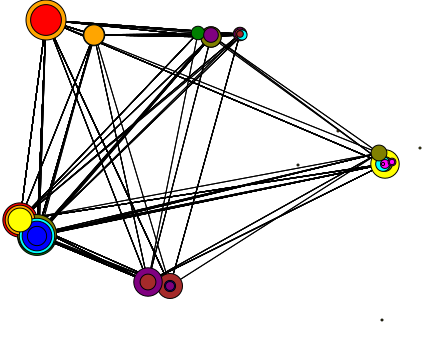

In [193]:
# create adjacency matrix 
G = nx.Graph(triangleSparse) # create graph from sparse data [UPDATE THIS]
adjacency = nx.adjacency_matrix(G) # create Adjacency matrix
adjacencyMatrix = sparse.csr_matrix(adjacency) # convert array to sparse row matrix form
print(adjacencyMatrix.shape[0])

## train classifier and build graph
louvain = LouvainNE(2)
embedding = louvain.fit_transform(adjacencyMatrix)
degrees = adjacency.dot(np.ones(adjacency.shape[0]))

labels = []
for i in range(adjacencyMatrix.shape[0]):
    labels.append(i)

image = svg_graph(adjacencyMatrix, position=embedding, display_edge_weight= True, display_node_weight=True, 
labels=labels, scale=1, filename="graph", directed=False)

#show graph
SVG(image)
